# Estival/PyMC

In this notebook, we will build a BayesianCompartmentalModel, and calibrate it using PyMC

In [1]:
# Uncomment to install in colab
#!pip install estival==0.2.1

In [2]:
# This is required for parallel evaluation in notebooks
# Note that if running under (non-WSL) Windows, you should
# disable this line, and use single threaded evaluation in pymc

import multiprocessing as mp
mp.set_start_method('forkserver')

In [3]:
import summer2
import numpy as np
import pandas as pd

In [4]:
from summer2.extras import test_models

In [5]:
m = test_models.sir()

In [6]:
defp = m.get_default_parameters()
defp

{'contact_rate': 0.4, 'recovery_rate': 0.1}

<Axes: >

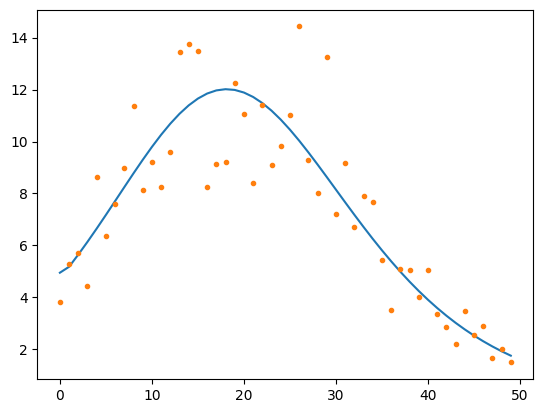

In [7]:
m.run({"contact_rate": 0.5, "recovery_rate": 0.4})
do_def = m.get_derived_outputs_df()
obs_clean = do_def["incidence"].iloc[0:50]
obs_noisy = obs_clean * np.exp(np.random.normal(0.0,0.2,len(obs_clean)))
obs_clean.plot()
obs_noisy.plot(style='.')

In [8]:
# The following imports are the 'building blocks' of estival models

# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
# Specify a Truncated normal target with a free dispersion parameter
targets = [
    est.TruncatedNormalTarget("incidence", obs_noisy, (0.0,np.inf),
        esp.UniformPrior("incidence_dispersion",(0.1, obs_noisy.max()*0.1)))
]

In [10]:
# Uniform priors over our 2 model parameters
priors = [
    esp.UniformPrior("contact_rate", (0.01,1.0)),
    esp.TruncNormalPrior("recovery_rate", 0.5, 0.2, (0.01,1.0)),
]

In [11]:
# The BayesianCompartmentalModel class is the primary entry point to all optimization and calibration
# methods in estival
# It takes a CompartmentalModel object, default parameters, priors, and targets
# The default parameters will be used as fixed values when no prior is specified for a given parameter

bcm = BayesianCompartmentalModel(m, defp, priors, targets)

In [12]:
from estival.calibration import pymc as epm

In [13]:
import pymc as pm

In [14]:
with pm.Model() as model:
    
    # This is all you need - a single call to use_model
    # include_ll will optionally output the BCM loglikelihood as a sampled value
    
    variables = epm.use_model(bcm, include_ll=True)
    
    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))
    
    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata_mh = pm.sample(step=[pm.DEMetropolis(variables)], draws=4000, tune=1000,cores=4,chains=4)

Population sampling (4 chains)
DEMetropolis: [contact_rate, recovery_rate, incidence_dispersion]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Using arviz to examine outputs

In [15]:
import arviz as az

In [16]:
az.summary(idata_mh)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,0.513,0.060,0.395,0.621,0.004,0.003,228.0,763.0,1.02
recovery_rate,0.417,0.057,0.309,0.519,0.004,0.003,226.0,830.0,1.02
incidence_dispersion,1.141,0.167,0.891,1.443,0.018,0.013,98.0,304.0,1.05
loglike,-2.978,0.845,-4.498,-1.965,0.026,0.018,749.0,1409.0,1.01


In [17]:
# Optional - select some subset out of the resulting trace - useful if
# you require additional burnin
# subset = idata_mh.sel(draw=slice(500, None), groups="posterior")

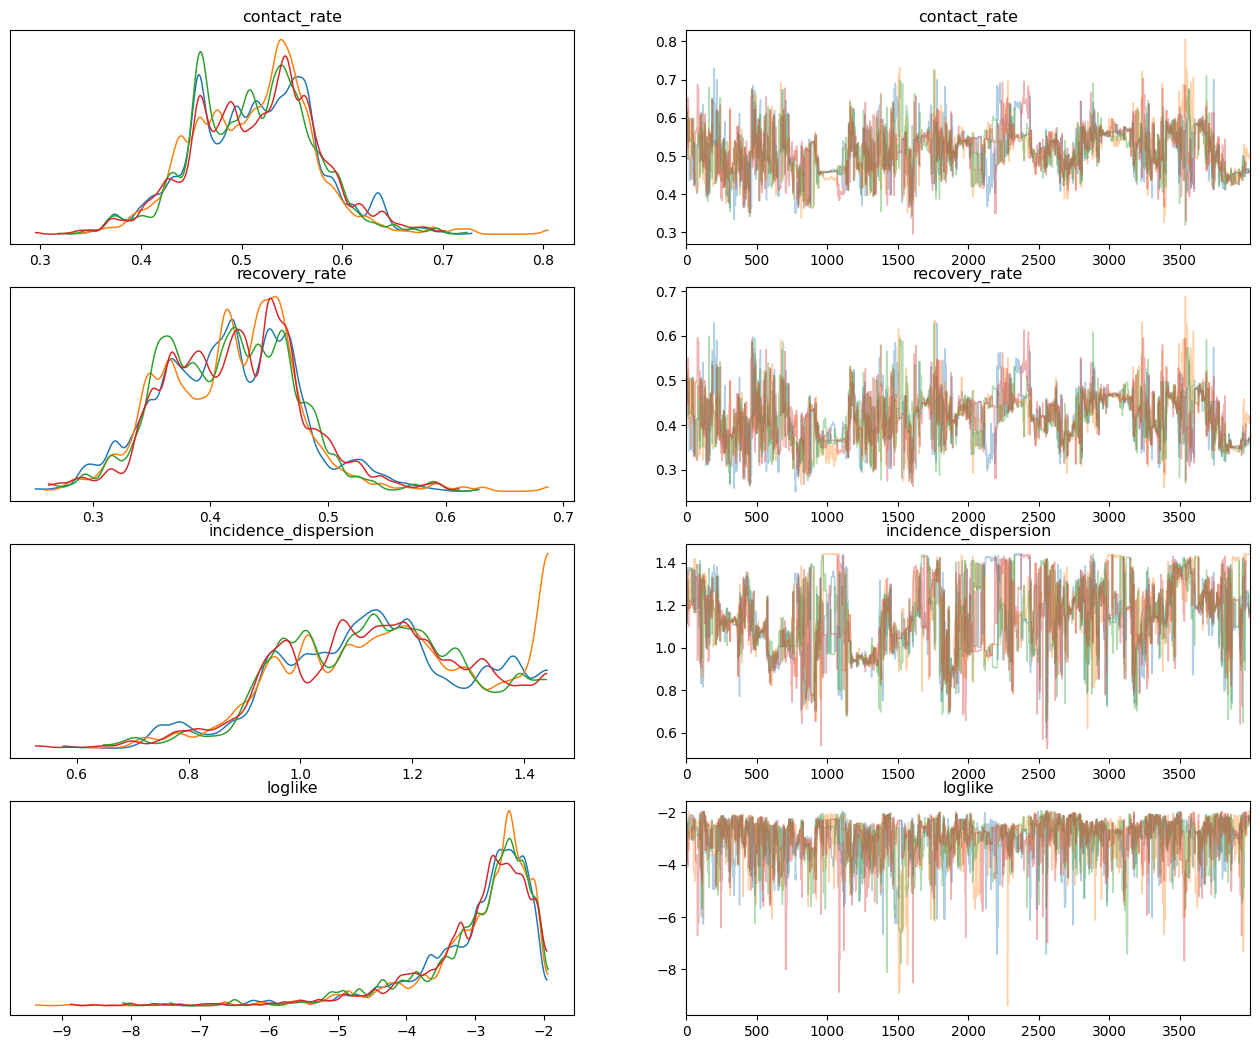

In [18]:
az.plot_trace(idata_mh, figsize=(16,3.2*len(idata_mh.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

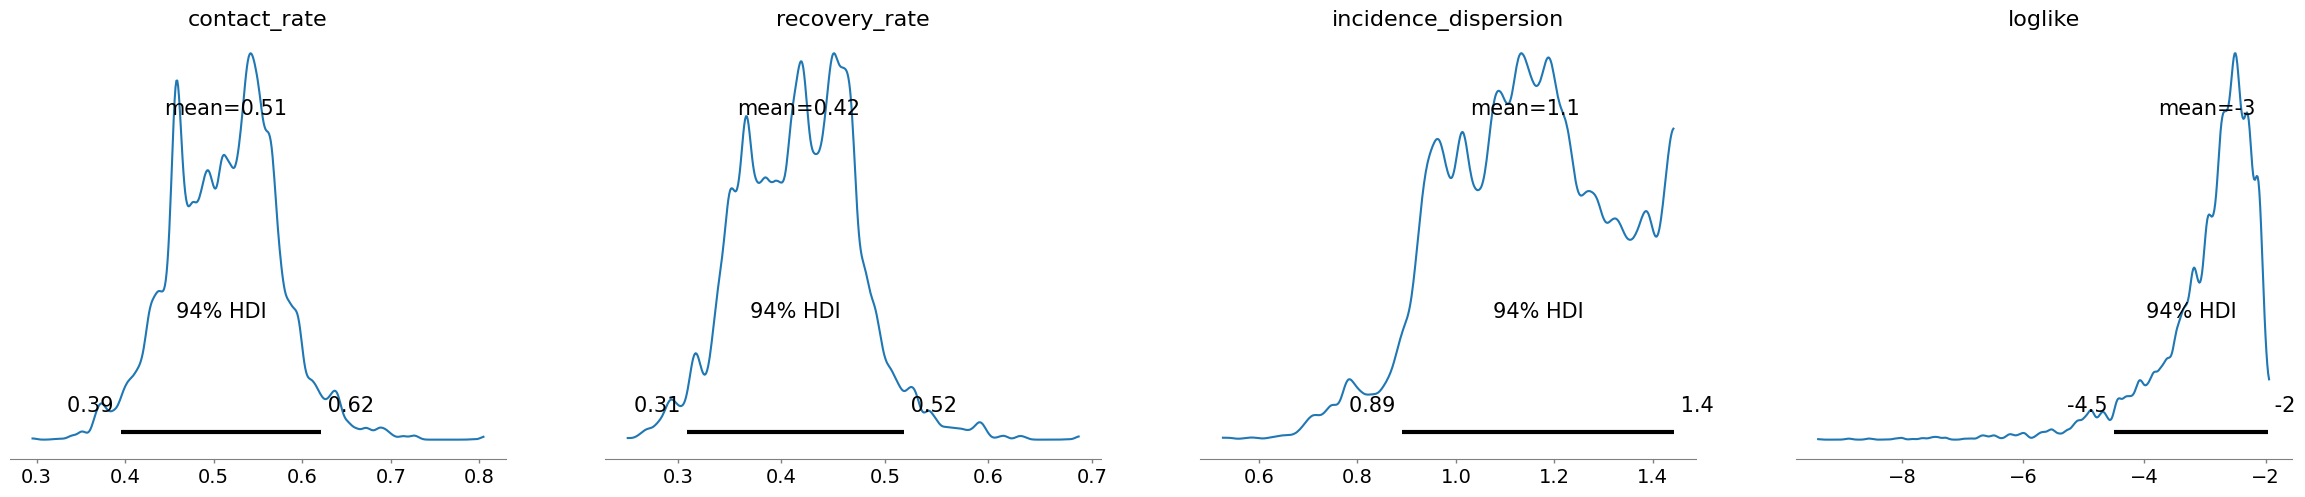

In [19]:
az.plot_posterior(idata_mh);

In [20]:
# If we have included the loglikelihood in our outputs, then obtaining the MLE is simple

caldf = idata_mh.to_dataframe(groups="posterior")
ll_sorted = caldf.sort_values(by="loglike", ascending=False)

In [21]:
ll_sorted

,chain,draw,contact_rate,recovery_rate,incidence_dispersion,loglike
10564,2,2564,0.481352,0.385298,1.407569,-1.937132
10563,2,2563,0.481352,0.385298,1.407569,-1.937132
6561,1,2561,0.479562,0.382788,1.410913,-1.938845
10515,2,2515,0.488030,0.391932,1.396258,-1.939133
10514,2,2514,0.488030,0.391932,1.396258,-1.939133
...,...,...,...,...,...,...
13083,3,1083,0.383158,0.340092,1.047815,-8.883315
13084,3,1084,0.383158,0.340092,1.047815,-8.883315
5508,1,1508,0.660946,0.589414,0.885021,-8.922695
5507,1,1507,0.660946,0.589414,0.885021,-8.922695


In [22]:
# Simply get the first item from our sorted Dataframe

mle_params = ll_sorted.iloc[0][list(bcm.priors)].to_dict()
mle_params

{'contact_rate': 0.48135221339246126,
 'recovery_rate': 0.38529769429840177,
 'incidence_dispersion': 1.4075693209631375}

In [23]:
# As you can see, this is exactly the value output from the original BCM
bcm.loglikelihood(**mle_params), ll_sorted.iloc[0]["loglike"]

(Array(-1.93713249, dtype=float64), -1.9371324934748193)

In [24]:
# Run the model with these parameters
mle_res = bcm.run(mle_params)

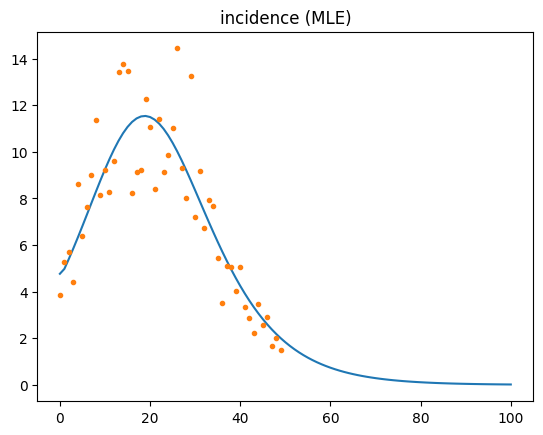

In [25]:
# ...and plot some results
variable = "incidence"

pd.Series(mle_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

In [26]:
# Do some basic uncertainty sampling

In [27]:
def sample_outputs(bcm, idata, n_samples):
    caldf = idata.to_dataframe(groups="posterior")
    caldf = caldf[list(bcm.priors)]
    draws = caldf.index
    sel_draws = np.random.choice(draws, n_samples, False)
    samples = caldf.loc[sel_draws]
    
    all_res = []
    for k,v in samples.iterrows():
        cur_sample = v.to_dict()
        all_res.append(bcm.run(cur_sample))
        
    return all_res

In [28]:
# Play around with n_samples to get a sense of what is required to accurately represent the posterior
all_res = sample_outputs(bcm, idata_mh, 400)

In [29]:
def get_uncertainty_quantiles(all_res, quantiles, variable):
    stacked_incidence = np.stack([res.derived_outputs[variable] for res in all_res])
    return pd.DataFrame(np.quantile(stacked_incidence, quantiles, axis=0).T, columns=quantiles)

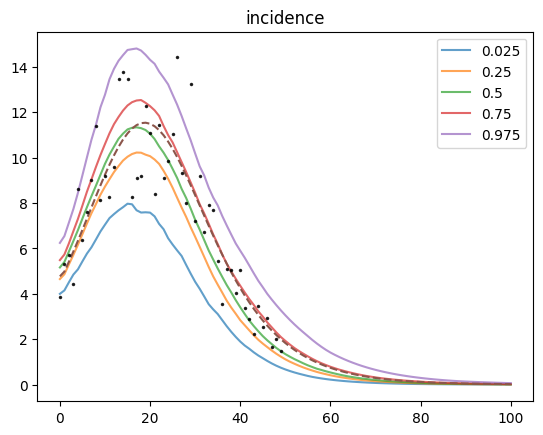

In [30]:
variable = "incidence"
quantiles = (0.025,0.25,0.5,0.75,0.975)

udf = get_uncertainty_quantiles(all_res, quantiles, variable)

fig = udf.plot(title=variable,alpha=0.7)
pd.Series(mle_res.derived_outputs[variable]).plot(style='--')
bcm.targets[variable].data.plot(style='.',color="black", ms=3, alpha=0.8);